# Part 4: Choose Our Own Adventure!
# Part 4



### Read Data

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-dark') 

In [2]:
# read in SOTU.csv using pandas, name the variable `sou` for simplicity
# the below cell is what the output should look like
sou = pd.read_csv("data/SOTU.csv")
sou

,President,Year,Text,Word Count
0,Joseph R. Biden,2024.0,"\n[Before speaking, the President presented hi...",8003
1,Joseph R. Biden,2023.0,\nThe President. Mr. Speaker——\n[At this point...,8978
2,Joseph R. Biden,2022.0,"\nThe President. Thank you all very, very much...",7539
3,Joseph R. Biden,2021.0,\nThe President. Thank you. Thank you. Thank y...,7734
4,Donald J. Trump,2020.0,\nThe President. Thank you very much. Thank yo...,6169
...,...,...,...,...
241,George Washington,1791.0,\nFellow-Citizens of the Senate and House of R...,2264
242,George Washington,1790.0,\nFellow-Citizens of the Senate and House of R...,1069
243,George Washington,1790.0,\nFellow-Citizens of the Senate and House of R...,1069
244,George Washington,1790.0,\nFellow-Citizens of the Senate and House of R...,1069


In [3]:
# check range of years in original data
print(sou['Year'].unique().min())
sou['Year'].unique().max()

1790.0


np.float64(2024.0)

In [4]:
import spacy
from tqdm import tqdm
from collections import Counter

nlp = spacy.load("en_core_web_sm")

## Part 4: Choose your own advecnture! 

For Part 4, I will choose the second option, **observing word frequency over time**, for five words:

1. inflation
2. health
3. China
4. terror
5. immigration

I have chosen words that were significant in specific time points as well as among from the Top 20 words in Part 2. 

### 1. Filter modern speeches
First, we filtered out modern speeches, specifically from 1900 to 2024, since it would give us a smaller and more consistent dataset. 

In [5]:
#Filtering out modern speeches (from 1900-2024)
#This gives us a smaller and more consistent dataset → better NLP
sou_modern = sou[sou["Year"].astype(int) >= 1900].copy()
sou_modern.reset_index(drop=True, inplace=True)

sou_modern.head()

,President,Year,Text,Word Count
0,Joseph R. Biden,2024.0,"\n[Before speaking, the President presented hi...",8003
1,Joseph R. Biden,2023.0,\nThe President. Mr. Speaker——\n[At this point...,8978
2,Joseph R. Biden,2022.0,"\nThe President. Thank you all very, very much...",7539
3,Joseph R. Biden,2021.0,\nThe President. Thank you. Thank you. Thank y...,7734
4,Donald J. Trump,2020.0,\nThe President. Thank you very much. Thank yo...,6169


### 2. Add token counts for normalization
Next, we will add token counts for normalization. We will reconstruct a processed_modern just like we did in part 2 where we created processed_docs. This helps us convert raw counts into frequency per 1,000 words so that speeches with more text don’t incorrectly “win”.

In [6]:
# Reprocess with spaCy to match filtered rows
processed_modern = [nlp(text) for text in tqdm(sou_modern["Text"], desc="Processing modern speeches")]

# Count tokens
sou_modern["TokenCount"] = [len(doc) for doc in processed_modern]

Processing modern speeches: 100%|██████████| 131/131 [02:31<00:00,  1.15s/it]


In [7]:
sou_modern["Year"].min(), sou_modern["Year"].max(), len(sou_modern)

(np.float64(1900.0), np.float64(2024.0), 131)

We check whether the sou_modern includes the right range of years. It seems correct. 

### 3. Function: Count a target lemma in a single doc
Next, we will convert the target word into a lowercase lemma form (for consistency) and count how many tokens in the doc match that lemma. 

In [8]:
def count_lemma_in_doc(doc, target_word):
    target = target_word.lower()
    return sum(
        1
        for token in doc
        if token.lemma_.lower() == target
        and not token.is_stop
        and not token.is_punct
        and not token.is_space
        and not token.like_num
    )

In [9]:
#example test run of Function
test_count = count_lemma_in_doc(processed_modern[0], "economy")
test_count

7

Here, we can see that the result of the function is an integer (could be 0–30 depending on the speech).

### 4. Count word frequency per speech and normalize
To compare keyword usage fairly across speeches of very different lengths, we calculate normalized word frequency:

How many times does the word appear per 1,000 tokens in the speech?

This prevents longer speeches from automatically having higher counts.
We do this by:
- Looping over each processed speech
- Counting the number of times the target lemma appears
- Dividing by the total number of tokens in the speech
- Multiplying by 1,000 to obtain frequency per 1,000 words
- Returning a list aligned with the filtered dataset (sou_modern)
This normalized metric allows meaningful trend analysis of how political topics rise and fall over time.

In [10]:
def get_word_frequency_over_time(processed_docs, df, target_word):
    freqs = []

    for doc, tok_count in zip(processed_docs, df["TokenCount"]):
        count = count_lemma_in_doc(doc, target_word)
        freq_per_1000 = (count / tok_count) * 1000  # normalize
        freqs.append(freq_per_1000)

    return freqs


In [11]:
#testing one word: Economy
sou_modern["economy_freq"] = get_word_frequency_over_time(
    processed_modern, sou_modern, "economy"
)

sou_modern[["Year", "economy_freq"]].head()

,Year,economy_freq
0,2024.0,0.667875
1,2023.0,0.513919
2,2022.0,1.376098
3,2021.0,0.823808
4,2020.0,0.665513


We can see that the frequency of the word 'economy' is printed out successfully using the function made above. 

Now we will repeat the same process for the five chosen words, which are:

1. inflation
2. health
3. China
4. terror
5. immigration

In [12]:
# Apply to selected keywords
keywords = ["inflation", "health", "china", "terror", "immigration"]
for word in keywords:
    sou_modern[f"{word}_freq"] = get_word_frequency_over_time(processed_modern, sou_modern, word)


### 5. Plotting frequency change for each of the five words
Lastly, we will plot the normalized frequency trends over time.

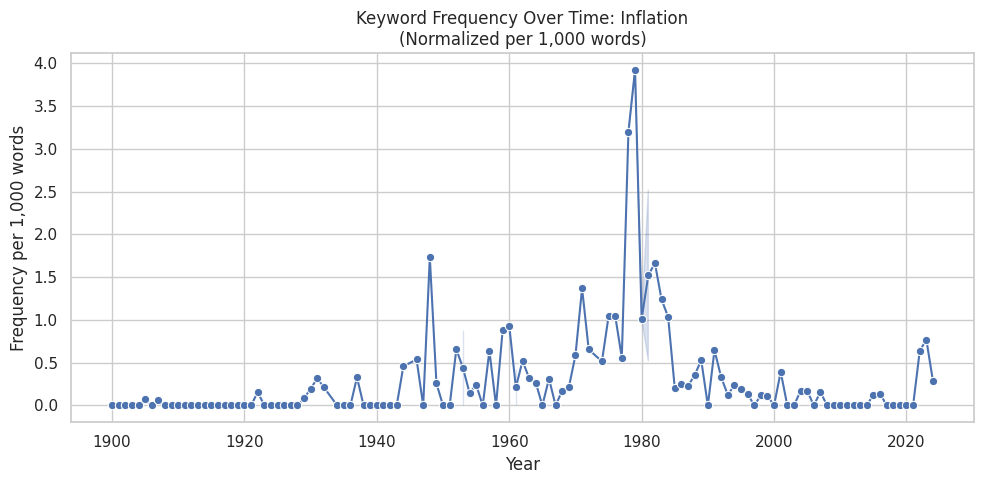

Saved plot: outputs/inflation_frequency_plot.png


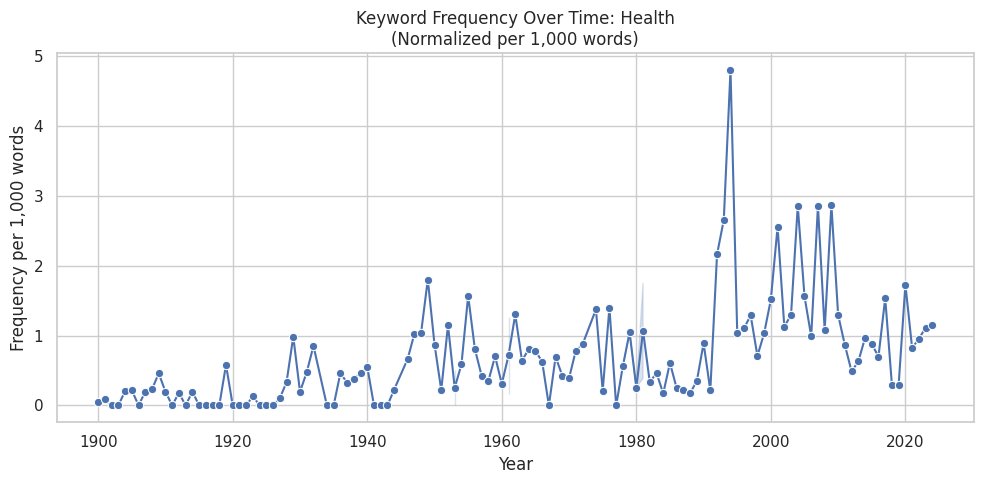

Saved plot: outputs/health_frequency_plot.png


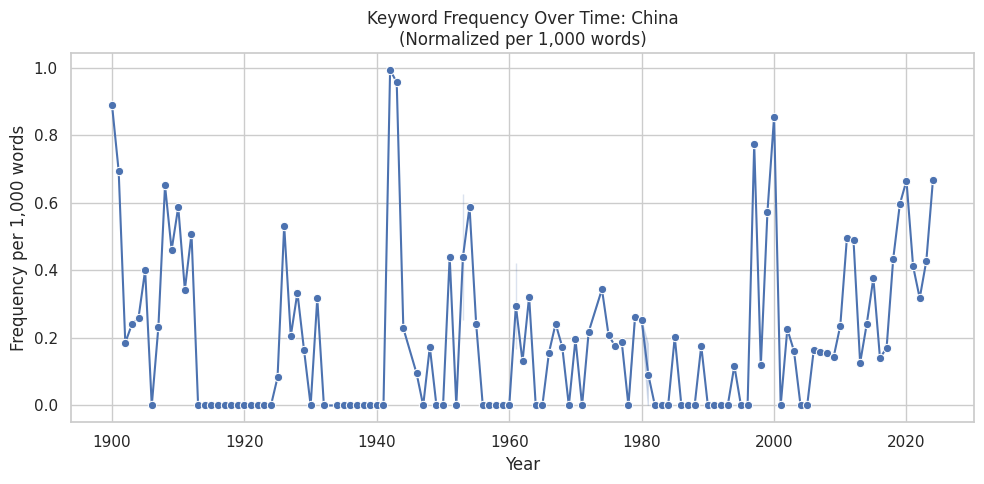

Saved plot: outputs/china_frequency_plot.png


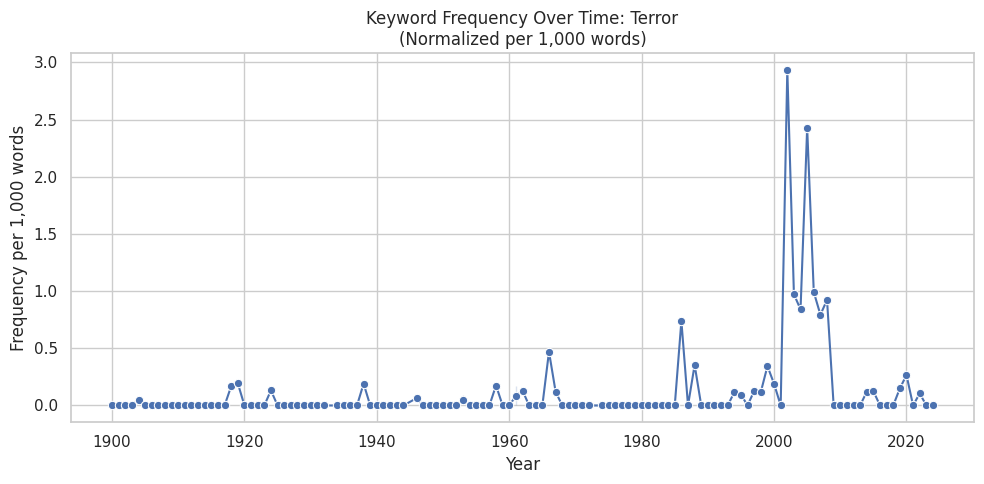

Saved plot: outputs/terror_frequency_plot.png


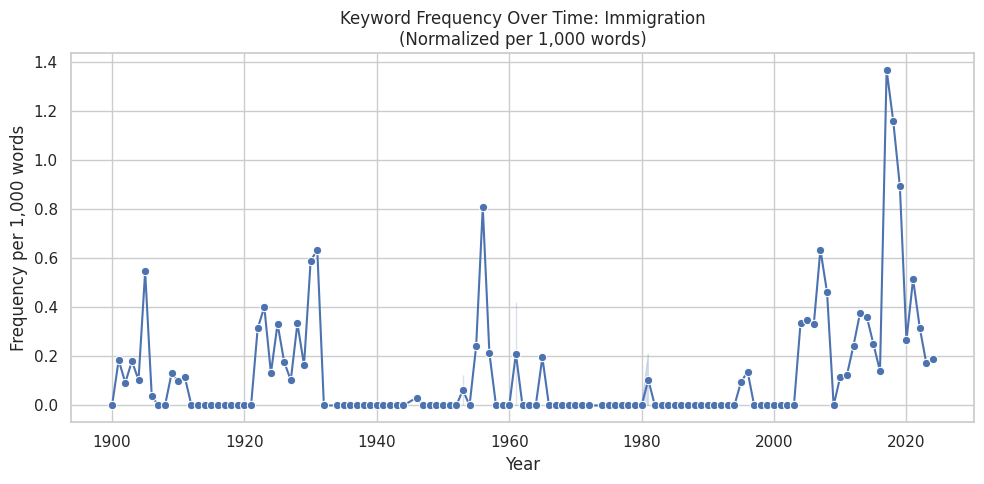

Saved plot: outputs/immigration_frequency_plot.png


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_theme(style="whitegrid")

def plot_each_word(df, words, save_dir="outputs"):
    
    # Ensure the directory exists (won't overwrite)
    os.makedirs(save_dir, exist_ok=True)
    
    for word in words:
        plt.figure(figsize=(10, 5))
        sns.lineplot(
            data=df,
            x="Year",
            y=f"{word}_freq",
            marker="o"
        )
        
        plt.title(f"Keyword Frequency Over Time: {word.capitalize()}\n(Normalized per 1,000 words)")
        plt.xlabel("Year")
        plt.ylabel("Frequency per 1,000 words")
        plt.tight_layout()
        
        # Save plot to outputs folder
        filename = f"{save_dir}/{word}_frequency_plot.png"
        plt.savefig(filename, dpi=300)
        
        plt.show()
        print(f"Saved plot: {filename}")

keywords = ["inflation", "health", "china", "terror", "immigration"]
plot_each_word(sou_modern, keywords)


### 6. Interpretation of the plots

## 📊 **Results: Keyword Frequency Trends in SOTU Speeches (1900–2024)**

### 🔹 Inflation
Over most of the 20th century, mentions of *inflation* are relatively rare, reflecting a historically stable price environment. Usage spikes sharply in the late 1970s and early 1980s, aligning with high U.S. inflation during the oil crisis and stagflation era. A smaller spike appears around 2022, consistent with the recent rise in inflation following the COVID-19 pandemic. These peaks closely track well-known periods of economic strain.

---

### 🔹 Health
References to *health* rise steadily starting mid-20th century as public health and healthcare infrastructure become national priorities. A major peak appears in the 1990s, followed by consistently heightened use in the 2000s and 2010s. This aligns with political focus on Medicare/Medicaid expansion, the Affordable Care Act, and aging population concerns. Health is clearly a growing long-term policy topic.

---

### 🔹 China
Discussion of *China* is minimal before the 1970s, consistent with limited diplomatic or economic engagement. Mentions rise significantly after the late 1990s, aligning with China’s rapid economic growth and increasing geopolitical importance. The upward trend continues into the 21st century, reflecting trade tensions, global supply chains, and national security concerns.

---

### 🔹 Terror
Mentions of *terror* remain nearly nonexistent before 2001. Following the 9/11 attacks, there is an immediate and dramatic spike, reflecting the central role of counter-terrorism in U.S. policy during the Bush administration. Frequency declines after the early 2010s as focus shifts toward other domestic and international priorities.

---

### 🔹 Immigration
References to *immigration* fluctuate modestly throughout the 20th century, with periodic peaks during policy reforms. A sustained rise emerges after ~2005, reflecting increasing political polarization around immigration, border security, and population shifts. The sharp increase in the late 2010s aligns with heightened debate during the Trump administration.
